In [1]:
import numpy as np
import os
import random
import scipy
from scipy import signal
from numpy.fft import fft
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import he_normal

from sklearn.model_selection import train_test_split

import pandas as pd
import pickle

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False, figsize=(16, 8)):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

In [3]:
def load_npy(hold_position):
    return np.load("train_" + hold_position + "_glo_mag_ver2_norm_time_melspectram.npy")

In [4]:
train_Bag = load_npy("Bag")
train_Hips = load_npy("Hips")
train_Torso = load_npy("Torso")
train_Hand = load_npy("Hand")

train_Hand.shape

(195490, 16, 32)

In [5]:
def load_npy(hold_position):
    return np.load("validation_" + hold_position + "_glo_mag_ver2_norm_time_melspectram.npy")

In [6]:
val_Bag = load_npy("Bag")
val_Hips = load_npy("Hips")
val_Torso = load_npy("Torso")
val_Hand = load_npy("Hand")

val_Hand.shape

(28685, 16, 32)

In [17]:
X_train = np.concatenate([train_Bag, train_Hips, train_Torso, train_Hand], axis=0)
X_val = np.concatenate([val_Bag, val_Hips, val_Torso, val_Hand], axis=0)

X_train.shape, X_val.shape

((781960, 16, 32), (114740, 16, 32))

In [15]:
Y_train = np.delete(np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_Label.npy")[:, 0], 120845, 0)
Y_val = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0]

Y_train.shape, Y_val.shape

((195490, 1), (28685,))

In [16]:
Y_train = np.concatenate([Y_train, Y_train, Y_train, Y_train], axis=0).reshape([-1])
Y_val = np.concatenate([Y_val, Y_val, Y_val, Y_val], axis=0)

Y_train.shape, Y_val.shape

((781960,), (114740,))

In [18]:
X_train = X_train / 255
X_val = X_val / 255

In [19]:
X_train = X_train.reshape([-1, X_train.shape[1], X_train.shape[2], 1])
X_val = X_val.reshape([-1, X_val.shape[1], X_val.shape[2], 1])

X_train.shape, X_val.shape

((781960, 16, 32, 1), (114740, 16, 32, 1))

In [20]:
X_train = X_train[(Y_train == 1) | (Y_train == 7) | (Y_train == 8)]
X_val = X_val[(Y_val == 1) | (Y_val == 7) | (Y_val == 8)]

X_train.shape, X_val.shape

((317164, 16, 32, 1), (58500, 16, 32, 1))

In [21]:
Y_train = Y_train[(Y_train == 1) | (Y_train == 7) | (Y_train == 8)].reshape([-1, 1])
Y_val = Y_val[(Y_val == 1) | (Y_val == 7) | (Y_val == 8)].reshape([-1, 1])

Y_train.shape, Y_val.shape

((317164, 1), (58500, 1))

In [22]:
Y_train = Y_train - 6
Y_val = Y_val - 6

Y_train[Y_train == -5] = 0
Y_val[Y_val == -5] = 0

np.unique(Y_train)

array([0., 1., 2.])

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, shuffle=False)

x_train.shape, y_train.shape

((222014, 16, 32, 1), (222014, 1))

In [24]:
model = tf.keras.Sequential()
# model.add(layers.Flatten())
model.add(layers.Conv2D(64, (3, 3), padding='valid', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1), kernel_initializer=he_normal()))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath="../Output/CheckPoint/model5_{epoch:02d}-{loss:.2f}-{accuracy:.2f}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5", 
                                           monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
history = model.fit(x_train, y_train, epochs=128, batch_size=3072, validation_data=(x_test, y_test), callbacks=[cp_cb, es_cb])

Train on 222014 samples, validate on 95150 samples
Epoch 1/128
222014/222014 [==============================] - 12s 55us/sample - loss: 1.0027 - accuracy: 0.4689 - val_loss: 59.2529 - val_accuracy: 0.3245
Epoch 2/128
222014/222014 [==============================] - 8s 36us/sample - loss: 0.9085 - accuracy: 0.5123 - val_loss: 10.2073 - val_accuracy: 0.3246: 1s - loss: 0 - ETA: 0s - loss: 0.9050 - accura
Epoch 3/128
222014/222014 [==============================] - 8s 36us/sample - loss: 0.8990 - accuracy: 0.5179 - val_loss: 4.0307 - val_accuracy: 0.3544
Epoch 4/128
222014/222014 [==============================] - 8s 35us/sample - loss: 0.8719 - accuracy: 0.5299 - val_loss: 8.0922 - val_accuracy: 0.33900.875 - ETA: 2s - ETA: 0s - loss: 0.8723 - accu
Epoch 5/128
222014/222014 [==============================] - 8s 36us/sample - loss: 0.8637 - accuracy: 0.5336 - val_loss: 1.2406 - val_accuracy: 0.3786
Epoch 6/128
222014/222014 [==============================] - 8s 36us/sample - loss: 0.8607 

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 30, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 30, 32)        18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 15, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 15, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 15, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 15, 32)         18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 7, 32)          0

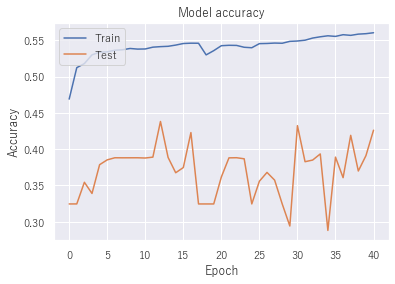

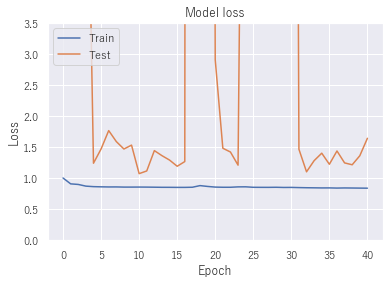

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim((0, 3.5))
plt.show()

In [29]:
model = tf.keras.models.load_model("../Output/CheckPoint/model5_11-0.86-0.54-1.07-0.39.hdf5")

0.26

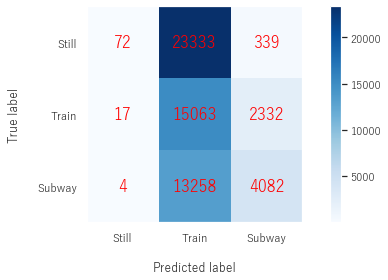

In [30]:
# class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
class_names = ["Still", "Train", "Subway"]
predict = model.predict_classes(X_val)
plot_confusion_matrix(Y_val, predict, class_names, False, (8, 4))
plt.grid(False)
f1_macro = f1_score(Y_val, predict, average='macro')
round(f1_macro, 3)